Step 0, Cost: 2.734860420227051
Step 10, Cost: 0.5073159337043762
Step 20, Cost: 0.055188193917274475
Step 30, Cost: 0.0003840794088318944
Step 40, Cost: 0.16399070620536804
Step 50, Cost: 0.005036711227148771
Step 60, Cost: 0.07350124418735504
Step 70, Cost: 0.03271622583270073
Step 80, Cost: 0.00045142770977690816
Step 90, Cost: 0.05850199982523918
Step 100, Cost: 1.1899981498718262
Step 110, Cost: 0.08927862346172333
Step 120, Cost: 0.003185876877978444
Step 130, Cost: 6.890564691275358e-06
Step 140, Cost: 0.005241376347839832
Step 150, Cost: 0.004462303593754768
Step 160, Cost: 0.002371524926275015
Step 170, Cost: 0.00011562521103769541
Step 180, Cost: 0.019518069922924042
Step 190, Cost: 0.016834817826747894
Step 200, Cost: 0.26168352365493774
Step 210, Cost: 1.8277857303619385
Step 220, Cost: 0.08574702590703964
Step 230, Cost: 0.006756946444511414
Step 240, Cost: 0.021123185753822327
Step 250, Cost: 0.007892314344644547
Step 260, Cost: 0.03405379131436348
Step 270, Cost: 8.23954

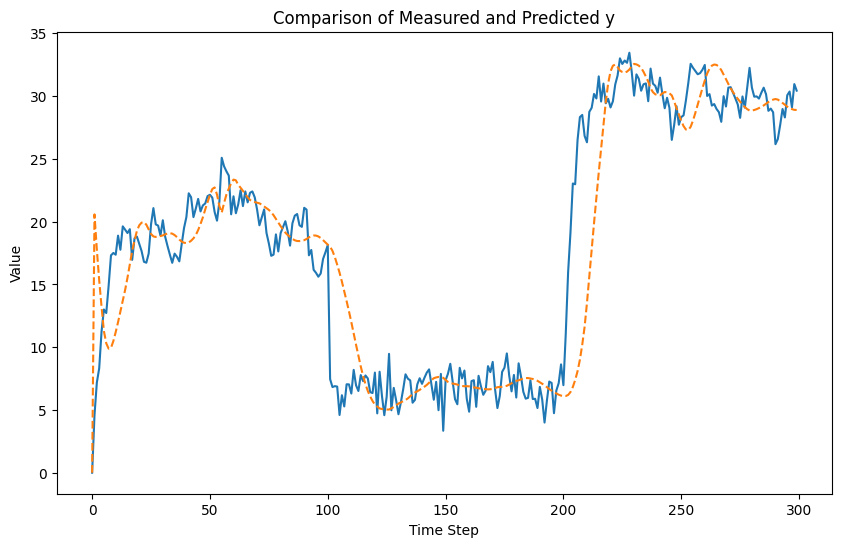

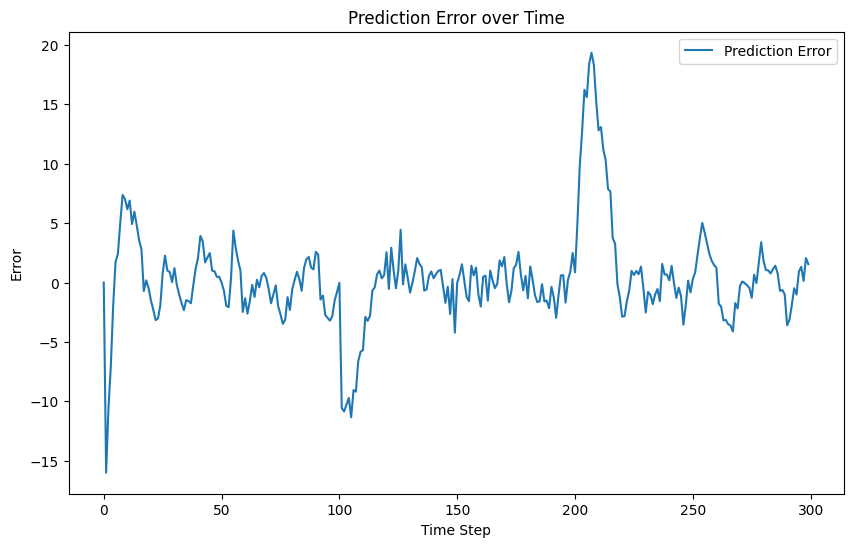

In [7]:
# Deep Learning 101 for Scientists and Engineers
# Chapter 5. Implementation of Transformers
# Yong-Jun Shin, 2024

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
num_past_values = 1
dim_embedding = 30
num_heads = 6
dim_feedforward = 120
num_layers = 180
learning_rate = 0.0001

# Generates amask for Transformer decoder self-attention
def create_subsequent_mask(size):
    # Create a square matrix of size 'size' initialized to 0
    mask = torch.zeros(size, size)
    # Set the last row and the last column to -1000000 to isolate y[n]
    mask[-1, :] = -1000000.0
    mask[:, -1] = -1000000.0
    return mask

# Define the Transformer model module (Python class)
class SimpleTransformerModel(nn.Module):
    def __init__(self, dim_embedding, num_heads, dim_feedforward, num_layers):
        super().__init__()
        self.transformer = nn.Transformer(
            d_model=dim_embedding,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.input_embedding = nn.Linear(1, dim_embedding)
        self.output_layer = nn.Linear(dim_embedding, 1)

    def forward(self, x_seq, y_seq):
        x_seq_embed = self.input_embedding(x_seq)
        y_seq_embed = self.input_embedding(y_seq)
        # Create a subsequent mask for the target sequence
        tgt_mask = create_subsequent_mask(num_past_values+1)
        # Pass the masked target sequence along with the source sequence to the transformer
        output = self.transformer(x_seq_embed, y_seq_embed, tgt_mask=tgt_mask)
        # output = self.transformer(x_seq_embed, y_seq_embed)
        return self.output_layer(output[-1, :])

# Instantiate the transformer model
model = SimpleTransformerModel(dim_embedding, num_heads, dim_feedforward, num_layers)

# Cost and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Simulation Data
N = 300
x = torch.randn(N) + 10
y = torch.empty(N)
y[0] = torch.tensor(0.0)
y[1] = 0.4 * x[0] + 0.8 * y[0] + torch.randn(1)
for i in range(2, N):
    y[i] = 0.4 * x[i-1] + 0.8 * y[i-1] + torch.randn(1)
    if i > 100:
        y[i] = 0.6 * x[i-1] + 0.1 * y[i-1] + torch.randn(1)
    if i > 200:
        y[i] = 0.6 * x[i-1] + 0.8 * y[i-1] + torch.randn(1)

# Normalize data
x_mean, x_std = x.mean(), x.std()
y_mean, y_std = y.mean(), y.std()
x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

# Simulation loop
model.eval()
predictions = []
for i in range(N - num_past_values):
    optimizer.zero_grad()
    src_seq = x_normalized[i:i + num_past_values]
    src_seq = src_seq.unsqueeze(-1)
    tgt_seq = y_normalized[i:i + num_past_values+1]
    tgt_seq = tgt_seq.unsqueeze(-1)
    tgt_output = y_normalized[i + num_past_values]
    predicted_output = model(src_seq, tgt_seq)
    predictions.append (predicted_output.item())
    cost = criterion(predicted_output, tgt_output)
    cost.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f'Step {i}, Cost: {cost.item()}')

# Denormalize predictions
predictions = (torch.tensor(predictions) * y_std) + y_mean
# Create zeros tensor
zeros = torch.zeros(num_past_values)
# Concatenate zeros to the beginning of 'predictions'
predictions = torch.cat((zeros, predictions), dim=0)
# Calculate prediction errors
prediction_error = y - predictions
# Calculate Mean Squared Error (MSE)
mse = np.mean((y.detach().numpy() - predictions.detach().numpy()) ** 2)
print(f'MSE: {mse}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y, label='Measured y')
plt.plot(predictions, label='Predicted y', linestyle='--')
plt.title('Comparison of Measured and Predicted y')
plt.xlabel('Time Step')
plt.ylabel('Value')

# Plot prediction error
plt.figure(figsize=(10, 6))
plt.plot(prediction_error, label='Prediction Error')
plt.title('Prediction Error over Time')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()


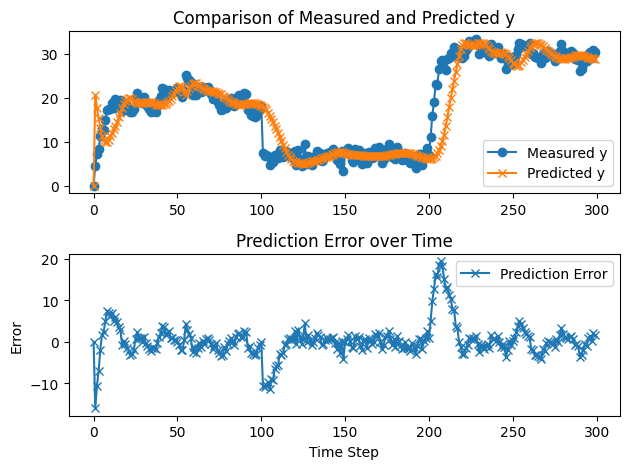

In [8]:
# Assuming you have a 'time' variable that corresponds to your data indices
time = torch.arange(0, y.size(0))

# Plot comparison of measured and predicted y
plt.subplot(2, 1, 1)  # This sets up the first subplot in a 2x1 grid
plt.plot(time.numpy(), y.numpy(), 'o-', label='Measured y')
plt.plot(time.numpy(), predictions.numpy(), 'x-', label='Predicted y')
plt.title('Comparison of Measured and Predicted y')
plt.legend()

# Plot prediction error
prediction_error = y - predictions
plt.subplot(2, 1, 2)  # This sets up the second subplot in a 2x1 grid
plt.plot(time.numpy(), prediction_error.numpy(), 'x-', label='Prediction Error')
plt.title('Prediction Error over Time')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()

# Show all plots
plt.tight_layout()
plt.show()